# Derivative_Observations_with_GPy

The derivative_observations kernel works in a very similar way to the coregionalisation kernel.

Two examples of it's usage are given below: first a 1D example, second an example in 2D with observations of the partial derivative in a selected dimension.

The first example considers a scenario in which we have observations of the function in one region of the input space ($0<X<5$), and observations of its derivative in another ($3<X<8$). It shows how the derivative observations improve the estimate of the underlying function in the second region.

The kernel defaults to an RBF, however, it is possible to use alternative stationary kernels. The file stationary_extended.py includes RBF, Matern52 and Matern32 as examples.


### Imports

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import GPy
from GPy.util.multioutput import build_XY
from gp_derivative_observations import GPDerivativeObservations
%matplotlib inline

# 1D Example

### Generate observations

In [14]:
seed=1
np.random.seed(seed=seed)

# Underlying function and derivatives
c = 1
f = lambda x: np.sin(c*x)
fp = lambda x: c*np.cos(c*x)

#build a design matrix with a column of integers indicating the output
nX0 = 15
nX1 = 10
X0 = np.random.uniform(0, 5, (nX0, 1))
X1 = np.random.uniform(3, 8, (nX1, 1))

#build a suitable set of observed variables
noise_error_1, noise_error_2 = (0.075, 0.075)
Y0 = f(X0) + np.random.randn(*X0.shape) * noise_error_1
Y1 = fp(X1) + np.random.randn(*X1.shape) * noise_error_2

### Plot underlying function and its derivative

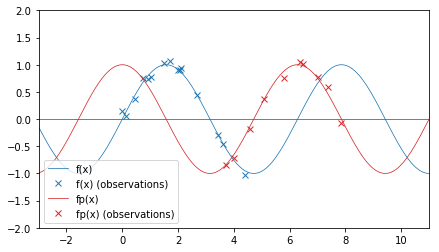

In [15]:
# Create densely sampled noise-free function values for plotting
nX0s = 200
nX1s = nX0s
plot_limits = [-3,11]
X0s = np.linspace(plot_limits[0], plot_limits[1], nX0s)
X1s = np.linspace(plot_limits[0], plot_limits[1], nX1s)
Xs = np.concatenate((X0s,X1s))
Y0s = f(X0s); Y1s = fp(X1s)

# Plot
_, ax = plt.subplots(figsize=(7,4))

def plot_func(ax=None):
    ax.hlines(0, plot_limits[0], plot_limits[1], lw=0.5)
    ax.plot(X0s,Y0s,'-',lw=0.75,color='C0', label='f(x)')
    ax.plot(X0,Y0,'x',label='f(x) (observations)',color='C0')
    return ax

def plot_deriv(ax=None):
    ax.plot(X1s,Y1s,'-',lw=0.75,color='C3', label='fp(x)')
    ax.plot(X1,Y1,'x',label='fp(x) (observations)',color='C3')
    return ax

ax = plot_func(ax)
ax = plot_deriv(ax)
ax.set_xlim(plot_limits)
ax.set_ylim([-2,2])
ax.legend()

### Fit simple GP
Fit simple GP without derivative observations

In [16]:
m_simple = GPy.models.GPRegression(X0, Y0, kernel=GPy.kern.ExpQuad(1,variance=5.01,lengthscale=5.02))
m_simple.optimize()
print(m_simple)


Name : GP regression
Objective : -7.102699680458855
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |             value  |  constraints  |  priors
  ExpQuad.variance         |    0.825796198325  |      +ve      |        
  ExpQuad.lengthscale      |     1.71710967452  |      +ve      |        
  Gaussian_noise.variance  |  0.00461468071551  |      +ve      |        


Now plot the optimised GP

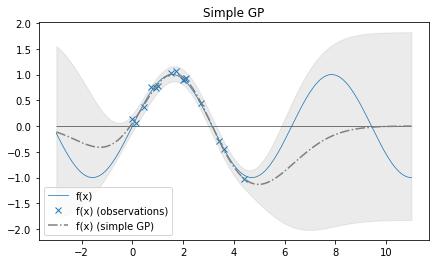

In [17]:
# first plot the true function again
_, ax = plt.subplots(figsize=(7,4))
ax = plot_func(ax)

# now plot the fitted GP
Ys_simple, Ys_var_simple = m_simple.predict(X0s.reshape(-1,1))
Ys_err = 2*np.sqrt(Ys_var_simple)
ax.plot(X0s.reshape(-1,1),Ys_simple[:nX0s,0],'-.',color='C7', label='f(x) (simple GP)')
ax.fill_between(X0s,Ys_simple[:nX0s,0]-Ys_err[:nX0s,0], 
                Ys_simple[:nX0s,0]+Ys_err[:nX0s,0],color='C7',alpha=0.15)
ax.legend(); ax.set_title('Simple GP')

### Derivative observations GP
Now fit derivative observations GP

In [18]:
#m = GPy.models.GPCoregionalizedRegression(X_list=[X0,X1], Y_list=[Y0,Y1]) # analagous to coregionalisation kernel
m = GPDerivativeObservations(X_list=[X0,X1], Y_list=[Y0,Y1])
m.optimize('bfgs', max_iters=100)
print(m)


Name : gp
Objective : -12.796724284652957
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  gp.                                    |             value  |  constraints  |  priors
  deriv_obs.ExpQuad.variance             |    0.905568733815  |      +ve      |        
  deriv_obs.ExpQuad.lengthscale          |     1.74413226847  |      +ve      |        
  mixed_noise.Gaussian_noise_0.variance  |  0.00433174858121  |      +ve      |        
  mixed_noise.Gaussian_noise_1.variance  |  0.00448028208722  |      +ve      |        


Now plot the optimised GP. Note how the observations of the derivative help ensure accurate estimates of the function in the region beyond the function observations (i.e. at $x>5$).

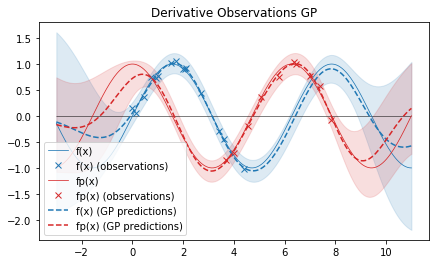

In [20]:
# First plot the true function and its derivative again
_, ax = plt.subplots(figsize=(7,4))
ax = plot_func(ax)
ax = plot_deriv(ax)

# Now plot derivative observations GP
Xs_, _, _ = build_XY([X0s.reshape(-1,1),X1s.reshape(-1,1)])
Ys, Ys_var = m.predict(Xs_, Y_metadata={'output_index':Xs_[:,-1,None].astype(int)})
Ys_var[:nX0s,:] += m.mixed_noise.Gaussian_noise_0.variance.values
Ys_var[nX0s:,:] += m.mixed_noise.Gaussian_noise_1.variance.values
Ys_err = 2*np.sqrt(Ys_var)

ax.plot(X0s.reshape(-1,1),Ys[:nX0s,0],'--',color='C0', label='f(x) (GP predictions)')
ax.fill_between(X0s,Ys[:nX0s,0]-Ys_err[:nX0s,0],Ys[:nX0s,0]+Ys_err[:nX0s,0],color='C0',alpha=0.15)
ax.plot(X1s.reshape(-1,1),Ys[nX0s:,0],'--',color='C3',label='fp(x) (GP predictions)')
ax.fill_between(X1s,Ys[nX0s:,0]-Ys_err[nX0s:,0],Ys[nX0s:,0]+Ys_err[nX0s:,0],color='C3',alpha=0.15)

ax.legend(); ax.set_title('Derivative Observations GP')

Alternatively, you can use the built-in GPy plotting methods for simpler usage at the expense of some control

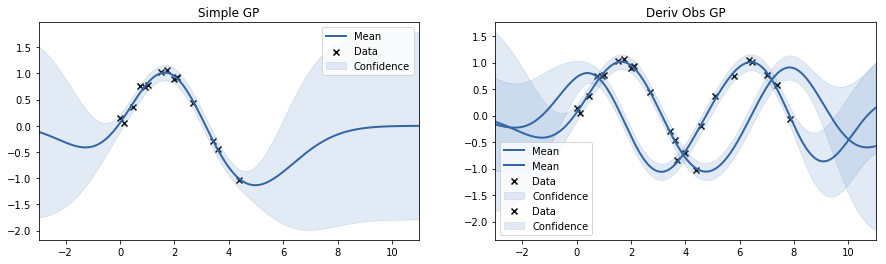

In [8]:
_, ax = plt.subplots(1,2, figsize=(15,4))

# Simple GP
m_simple.plot(plot_limits=plot_limits, ax=ax[0], title='Simple GP')

# Derivative observations GP
slices = GPy.util.multioutput.get_slices([X0,X1])
ax2 = m.plot(fixed_inputs=[(1,0)],which_data_rows=slices[0],Y_metadata={'output_index':0},plot_limits=plot_limits,ax=ax[1], title='Deriv Obs GP')
m.plot(fixed_inputs=[(1,1)],which_data_rows=slices[1],Y_metadata={'output_index':1},plot_limits=plot_limits,ax=ax[1])

# 2D Example
It is also possible to use observations of the partial derivative(s) wrt selected dimension(s) in a multi-dimensional setting.

### Generate data

In [9]:
# sample inputs and outputs
plot_lims = [0,7]
nX = 24
X = np.random.uniform(0,7,(nX,2))
R = np.sqrt(np.sum(X**2, axis=1)).reshape(-1,1)
c1 = 1; c2 = 0.4
Y0 = c2*X[:,0,None] + np.sin(c1*X[:,1,None]) + np.random.randn(nX,1)*0.05   # y

### Fit a simple GP model


Name : GP regression
Objective : 3.629244011922342
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |             value  |  constraints  |  priors
  ExpQuad.variance         |     2.74661536343  |      +ve      |        
  ExpQuad.lengthscale      |     2.53230561023  |      +ve      |        
  Gaussian_noise.variance  |  0.00172642120423  |      +ve      |        


 C:\Users\ball3716\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\figure.py:1743: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


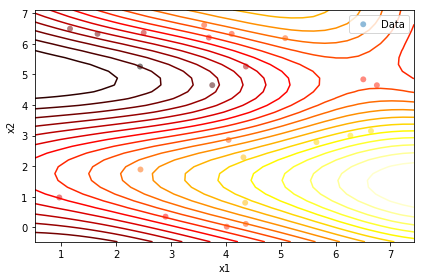

In [10]:
ker = GPy.kern.ExpQuad(2)
m_simple = GPy.models.GPRegression(X,Y0,ker)
m_simple.optimize(max_f_eval = 1000)
print(m_simple)

ax = m_simple.plot()
ax.set_xlabel('x1')
ax.set_ylabel('x2')

### Fit derivative observations GP
The key thing here is to define the index, which denotes which partial derivatives are observed.

- 0 = the function value
- 1 = partial derivative wrt the 1st dimension
- 2 = partial derivative wrt the 2nd dimension etc.

In [11]:
Y12 = c1*np.cos(c1*X[:,1,None]) + np.random.randn(nX,1)*0.05           # dy_dx1
Y11 = c2 + np.random.randn(nX,1)*0.05                                  # dy_dx2

index=[0,1,2]
m = GPDerivativeObservations(X_list=[X,X,X], Y_list=[Y0,Y11,Y12], index=index)
m.optimize('bfgs', max_iters=100)
print(m)


Name : gp
Objective : -57.46014755687525
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  gp.                                    |              value  |  constraints  |  priors
  deriv_obs.ExpQuad.variance             |      3.89173659513  |      +ve      |        
  deriv_obs.ExpQuad.lengthscale          |       2.8082357415  |      +ve      |        
  mixed_noise.Gaussian_noise_0.variance  |   0.00216476159982  |      +ve      |        
  mixed_noise.Gaussian_noise_1.variance  |  0.000951623743163  |      +ve      |        
  mixed_noise.Gaussian_noise_2.variance  |   0.00313921602269  |      +ve      |        


### 1D plot slices

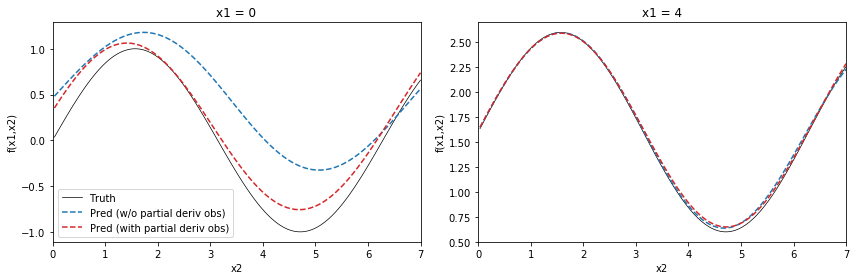

In [12]:
slices = [0, 4]
deriv_dim = 1
fig, ax = plt.subplots(1, len(slices), figsize=(12,4))
nXs=200                                         # dense sampling for plotting
for i, y in zip(range(len(slices)), slices):
    Xs = np.linspace(*plot_lims,nXs)
    Xs = (np.concatenate((Xs,Xs))).reshape(-1,2)
    Xs[:,1-deriv_dim] = slices[i]*np.ones_like(Xs[:,0])
    Xs_, _, _ = build_XY([Xs,Xs,Xs],index=index)
    _,id_u = np.unique(Xs_[:,-1,None],return_inverse=True)
    output_index = (id_u.min() + id_u).reshape(Xs_[:,-1,None].shape)
    
    # Truth
    Ys_true = c2*Xs[:,0,None] + np.sin(c1*Xs[:,1,None])
    ax[i].plot(Xs[:int(nXs/2),deriv_dim], Ys_true[:int(nXs/2),0], 'k-', lw= 0.7,
                  label='Truth')
    ax[i].set_xlim(plot_lims)
    
    # Simple GP
    Ys, _ = m_simple.predict(Xs)
    ax[i].plot(Xs[:int(nXs/2),deriv_dim], Ys[:int(nXs/2),0],'--',color='C0', 
                  label='Pred (w/o partial deriv obs)')
    
    # Derivative observations GP
    Ys, _ = m.predict(Xs_, Y_metadata={'output_index':output_index})
    ax[i].plot(Xs[:int(nXs/2),deriv_dim], Ys[:int(nXs/2),0],'--',color='C3', 
                  label='Pred (with partial deriv obs)')
    
    # Title, axis labels
    ax[i].set_title('x1 = {}'.format(slices[i]))
    ax[i].set_xlabel('x2')
    ax[i].set_ylabel('f(x1,x2)')

ax[0].legend(loc='lower left')
fig.tight_layout()